## Load and clean data, define test scenarios

In [ ]:
import os
import pandas as pd
import numpy as np
from feature_split import split_features, get_feature_indices

# 1) Read and concatenate CSV files
csv_dir = 'CIC-IDS-2017'
df_list = []
for fname in os.listdir(csv_dir):
    if fname.endswith('.csv'):
        df_list.append(pd.read_csv(os.path.join(csv_dir, fname)))
df = pd.concat(df_list, ignore_index=True)

# Remove leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# 2) Basic cleaning: replace infinities and drop null values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 3) Subset by label
df_benign       = df[df['Label'] == 'BENIGN']
df_slowloris    = df[df['Label'] == 'DoS slowloris']
df_slowhttptest = df[df['Label'] == 'DoS Slowhttptest']

# 4) Split features by type: continuous vs discrete
feature_df = df.drop('Label', axis=1)
cont_cols, disc_cols = split_features(feature_df)
cont_idx, disc_idx   = get_feature_indices(feature_df, cont_cols, disc_cols)

# 5) Print checks
print(f"Continuous features ({len(cont_cols)}):")
for c in cont_cols:
    print(f"  - {c}")

print(f"\nDiscrete features ({len(disc_cols)}):")
for c in disc_cols:
    print(f"  - {c}")

# 6) Define four test scenarios
tests = {
    'Test1': {
        'benign':       len(df_slowloris),
        'slowloris':    len(df_slowloris),
        'slowhttptest': len(df_slowloris),
    },
    'Test2': {
        'benign':       len(df_benign),
        'slowloris':    len(df_slowloris),
        'slowhttptest': len(df_slowhttptest),
    },
    'Test3': {
        'benign':       len(df_slowloris) // 2,
        'slowloris':    len(df_slowloris) // 2,
        'slowhttptest': len(df_slowhttptest) // 2,
    },
    'Test4': {
        'benign':       len(df_slowloris) * 2,
        'slowloris':    len(df_slowloris),
        'slowhttptest': len(df_slowhttptest),
    },
}

# 7) Print scenario checks
for name, sizes in tests.items():
    print(f"{name}: BENIGN={sizes['benign']}, Slowloris={sizes['slowloris']}, Slowhttptest={sizes['slowhttptest']}")

Continuous features (60):
  - Destination Port
  - Flow Duration
  - Total Fwd Packets
  - Total Backward Packets
  - Total Length of Fwd Packets
  - Total Length of Bwd Packets
  - Fwd Packet Length Max
  - Fwd Packet Length Min
  - Fwd Packet Length Mean
  - Fwd Packet Length Std
  - Bwd Packet Length Max
  - Bwd Packet Length Min
  - Bwd Packet Length Mean
  - Bwd Packet Length Std
  - Flow Bytes/s
  - Flow Packets/s
  - Flow IAT Mean
  - Flow IAT Std
  - Flow IAT Max
  - Flow IAT Min
  - Fwd IAT Total
  - Fwd IAT Mean
  - Fwd IAT Std
  - Fwd IAT Max
  - Fwd IAT Min
  - Bwd IAT Total
  - Bwd IAT Mean
  - Bwd IAT Std
  - Bwd IAT Max
  - Bwd IAT Min
  - Fwd Header Length
  - Bwd Header Length
  - Fwd Packets/s
  - Bwd Packets/s
  - Min Packet Length
  - Max Packet Length
  - Packet Length Mean
  - Packet Length Std
  - Packet Length Variance
  - Down/Up Ratio
  - Average Packet Size
  - Avg Fwd Segment Size
  - Avg Bwd Segment Size
  - Fwd Header Length.1
  - Subflow Fwd Packets
  - S

In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.covariance import EmpiricalCovariance
from augment_module import augment_cvae, augment_gan

def apply_augmentation(
    X_train, y_train,
    method,
    cont_idx, disc_idx,
    imbalance_thresh: float = 0.10,
    outlier_thresh: float = 3.0
):
    """
    Supported methods: 'None','SMOTENC','CVAE','GAN'
      - Only augment if the minority class proportion < imbalance_thresh (default 0.10)
      - SMOTENC: Over-sample both continuous and discrete features
      - CVAE/GAN: Apply outlier filtering after generation, and sync filter y_gen
      - If X_gen is empty, skip augmentation
    """
    # 1) imbalance check
    classes, counts = np.unique(y_train, return_counts=True)
    if method == 'None' or counts.min() / counts.sum() >= imbalance_thresh:
        return X_train, y_train

    # 2) Augmentation branch
    if method == 'CVAE':
        X_gen, y_gen = augment_cvae(X_train, y_train)
    elif method == 'GAN':
        X_gen, y_gen = augment_gan(X_train, y_train)
    elif method == 'SMOTENC':
        sampler = SMOTENC(
            categorical_features=disc_idx,
            sampling_strategy='minority',
            random_state=42
        )
        X_res_full, y_res_full = sampler.fit_resample(X_train, y_train)
        n_new = len(y_res_full) - len(y_train)
        X_gen = X_res_full[-n_new:]
        y_gen = y_res_full[-n_new:]
    else:
        return X_train, y_train

    # If no new samples are generated, skip augmentation
    if X_gen.shape[0] == 0:
        return X_train, y_train

    # 3) Quality filtering: Impute mean for X_train and X_gen, then compute Mahalanobis distance
    imp = SimpleImputer(strategy='mean')
    X_train_imp = imp.fit_transform(X_train)
    X_gen_imp   = imp.transform(X_gen)

    cov = EmpiricalCovariance().fit(X_train_imp)
    md = cov.mahalanobis(X_gen_imp)
    mask = md < outlier_thresh
    X_gen = X_gen[mask]
    y_gen = y_gen[mask]

    # If no samples remain after filtering, skip augmentation
    if X_gen.shape[0] == 0:
        return X_train, y_train

    # 4) Merge original and augmented data
    X_res = np.vstack([X_train, X_gen])
    y_res = np.concatenate([y_train, y_gen])

    return X_res, y_res


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Data augmentation methods
methods = ['None', 'SMOTENC', 'CVAE', 'GAN']

# Model list
# 1) Only use MLP and Logistic Regression
# 2) Other models (XGBoost, RF) will be defined in later code
# 3) Use MLP with a single hidden layer
# 4) Logistic Regression will use standardization

# Define the range of epochs to test
epoch_range = [1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 100]

# Dynamically generate model configurations to avoid repetition
models = {}
for ep in epoch_range:
    models[f'MLP-{ep}ep'] = MLPClassifier(
        hidden_layer_sizes=(32,),
        max_iter=ep,
        tol=1e-3,
        random_state=42,
        early_stopping=False
    )
    models[f'LogReg-{ep}ep'] = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            max_iter=ep,
            tol=1e-3,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    )
    # Add Random Forest and XGBoost models
    models[f'RF-{ep}ep'] = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    models[f'XGB-{ep}ep'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)

In [ ]:
import os
import logging
# Suppress TensorFlow/absl logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pandas as pd

# Load cont_idx, disc_idx

# Ensure results directory exists
os.makedirs('results', exist_ok=True)

confusion_records = []
cr_records        = []

count_key = {
    'BENIGN':           'BenignN',
    'DoS slowloris':    'SlowlorisN',
    'DoS Slowhttptest': 'SlowhttptestN'
}


# Only run Test2 for now
tests = {'Test2': tests['Test2']}

for test_name, sizes in tests.items():
    print(f"\n=== Scenario: {test_name} ===")
    # Downsample BENIGN
    keep_benign = min(sizes['benign'], 50000)
    b  = df_benign.sample(n=keep_benign, random_state=42, replace=(keep_benign>len(df_benign)))
    s1 = df_slowloris.sample(n=sizes['slowloris'], random_state=42, replace=(sizes['slowloris']>len(df_slowloris)))
    s2 = df_slowhttptest.sample(n=sizes['slowhttptest'], random_state=42, replace=(sizes['slowhttptest']>len(df_slowhttptest)))

    sample_counts = {
        'Scenario':       test_name,
        'BenignN':        len(b),
        'SlowlorisN':     len(s1),
        'SlowhttptestN':  len(s2)
    }
    print("Sample counts →", sample_counts)

    # Merge and shuffle
    data = pd.concat([b, s1, s2]).sample(frac=1, random_state=42).reset_index(drop=True)
    X, y = data.drop('Label', axis=1).values, data['Label'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    le = LabelEncoder().fit(y_train)
    y_train_enc, y_test_enc = le.transform(y_train), le.transform(y_test)

    for method in methods:
        # Augmentation
        X_res, y_res = apply_augmentation(X_train, y_train_enc, method, cont_idx, disc_idx)
        # Imputation
        imputer = SimpleImputer(strategy='mean')
        X_res      = imputer.fit_transform(X_res)
        X_test_imp = imputer.transform(X_test)

        for model_name, clf in models.items():
            # Training
            clf.fit(X_res, y_res)
            # Prediction
            y_pred_enc = clf.predict(X_test_imp)
            y_pred     = le.inverse_transform(y_pred_enc)

            # Confusion Matrix records
            cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
            for i, actual in enumerate(le.classes_):
                row = {'Scenario': test_name, 'Augmentation': method, 'Model': model_name, 'ActualClass': actual}
                for j, pred in enumerate(le.classes_):
                    row[f'Pred_{pred}'] = cm[i, j]
                confusion_records.append(row)

            # Classification Report records
            cr_dict = classification_report(y_test, y_pred, output_dict=True)
            cr_df   = pd.DataFrame(cr_dict).transpose()
            for cls in le.classes_:
                metrics = cr_df.loc[cls]
                row = {
                    'Scenario':     test_name,
                    'Augmentation': method,
                    'Model':        model_name,
                    'Class':        cls,
                    'Precision':    metrics['precision'],
                    'Recall':       metrics['recall'],
                    'F1-Score':     metrics['f1-score'],
                    'Support':      metrics['support'],
                    'TotalSamples': sample_counts[count_key[cls]]
                }
                cr_records.append(row)

# 4) Save results
pd.DataFrame(confusion_records).to_csv('results/confusion_matrices_all.csv', index=False)
pd.DataFrame(cr_records).to_csv('results/classification_reports_all.csv', index=False)

print("Aggregated CSVs saved to 'results/' directory:")
print(" - confusion_matrices_all.csv")
print(" - classification_reports_all.csv") 


=== Scenario: Test2 ===
Sample counts → {'Scenario': 'Test2', 'BenignN': 50000, 'SlowlorisN': 5796, 'SlowhttptestN': 5499}


/Users/eric/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eric/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/U

Aggregated CSVs saved to 'results/' directory:
 - confusion_matrices_all.csv
 - classification_reports_all.csv


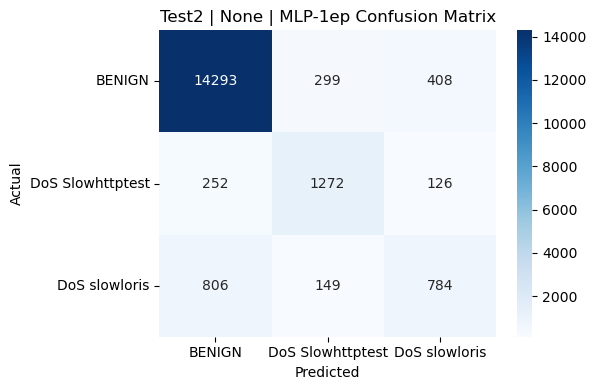

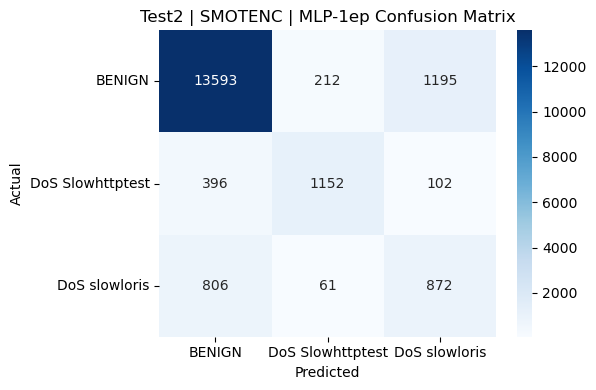

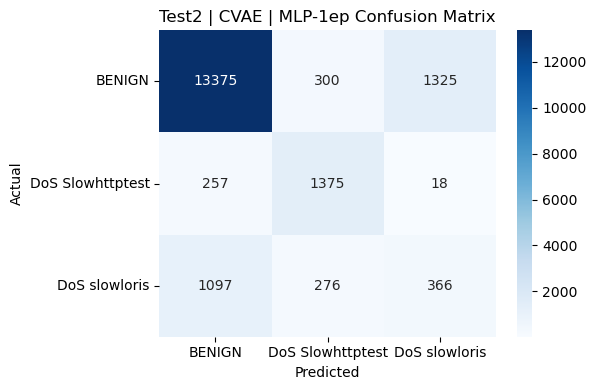

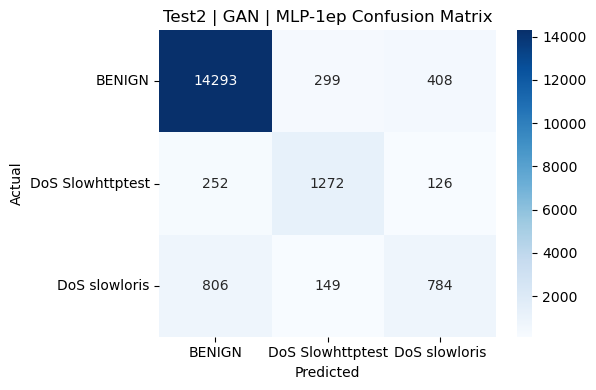

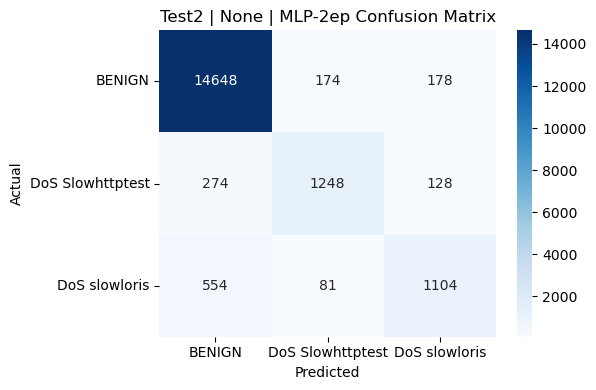

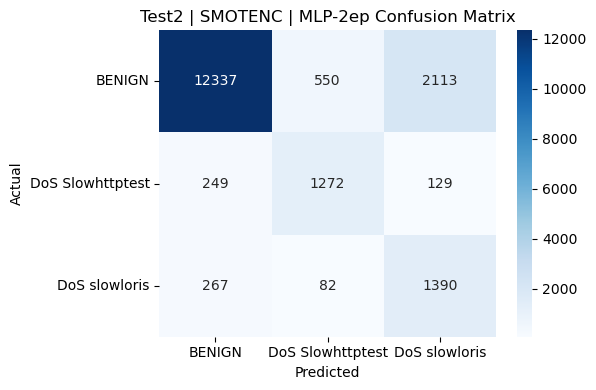

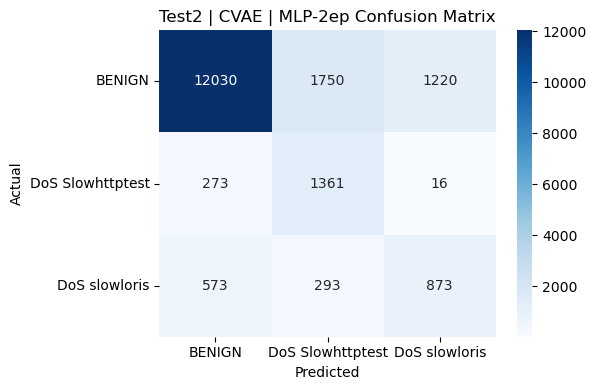

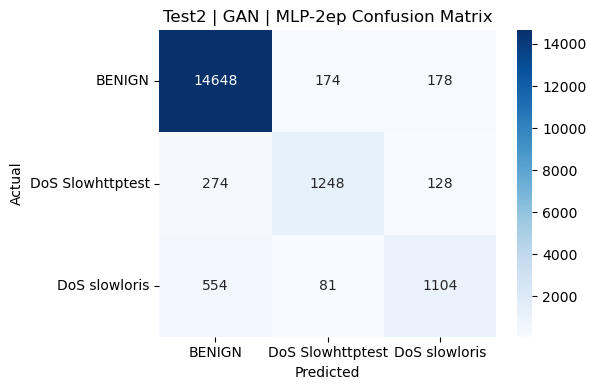

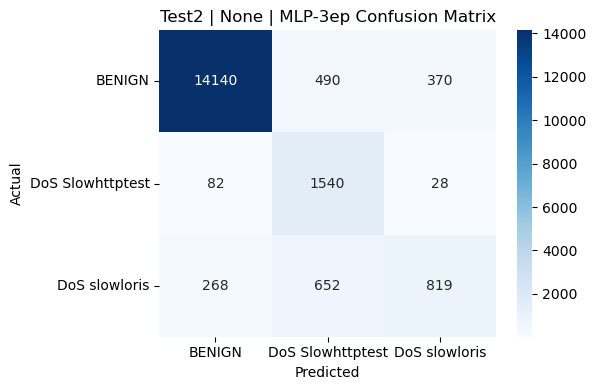

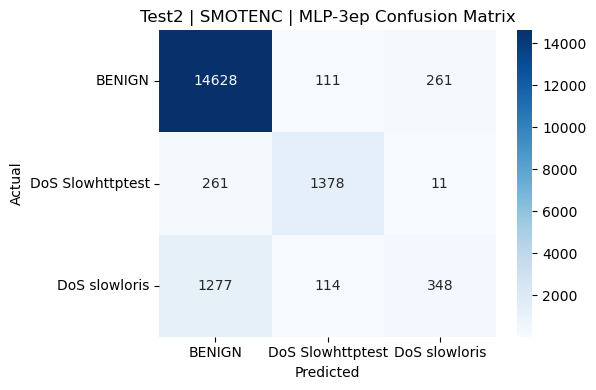

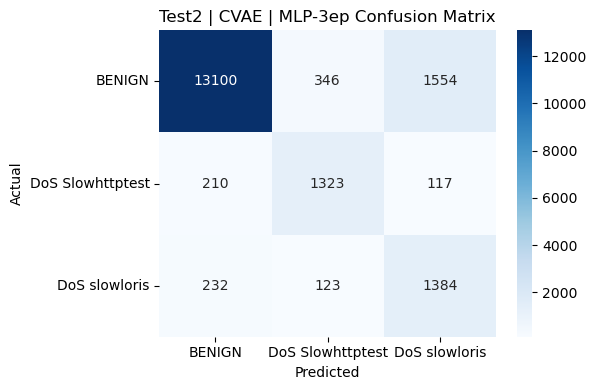

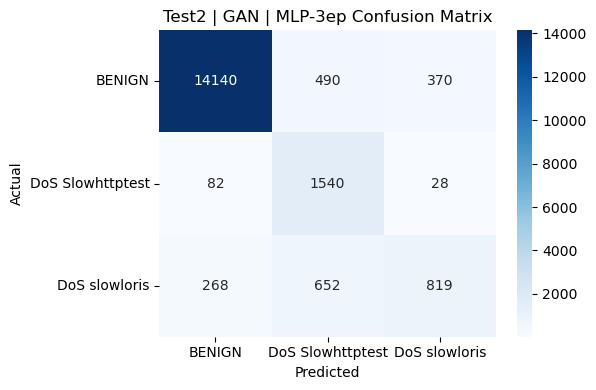

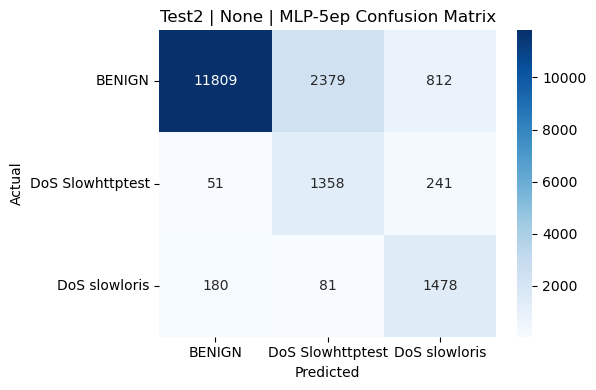

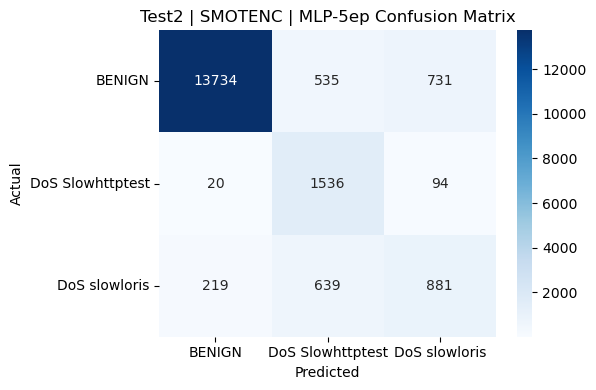

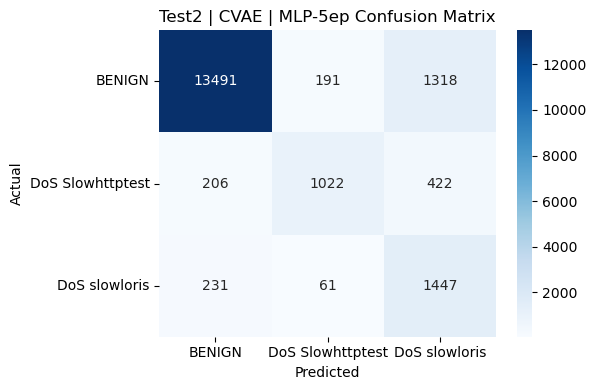

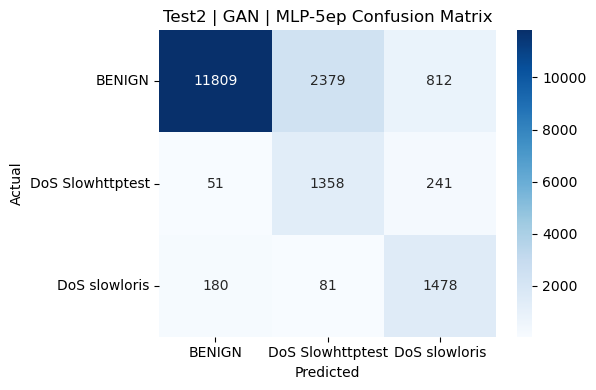

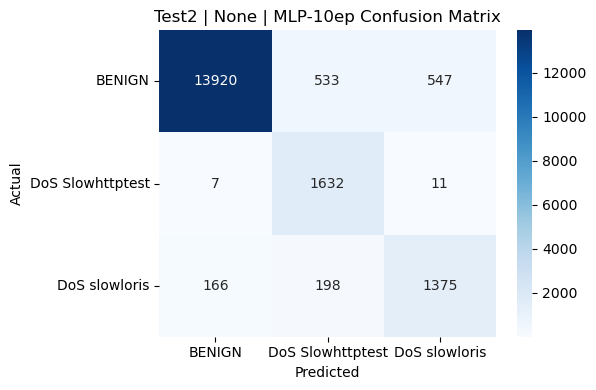

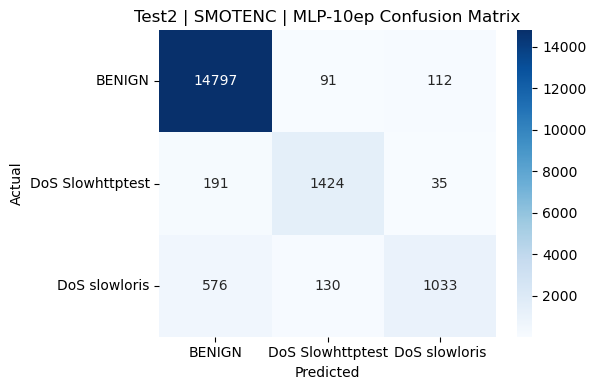

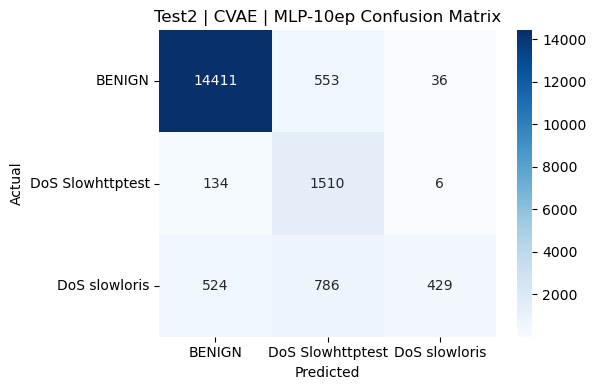

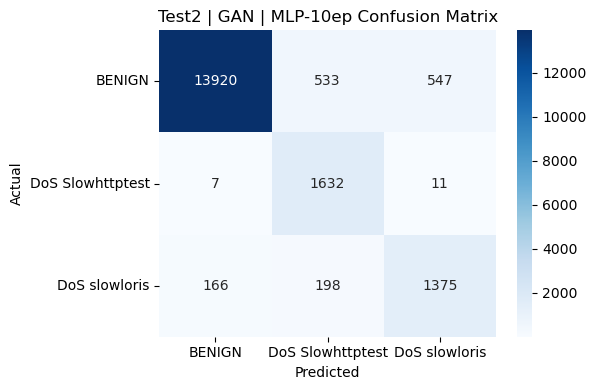

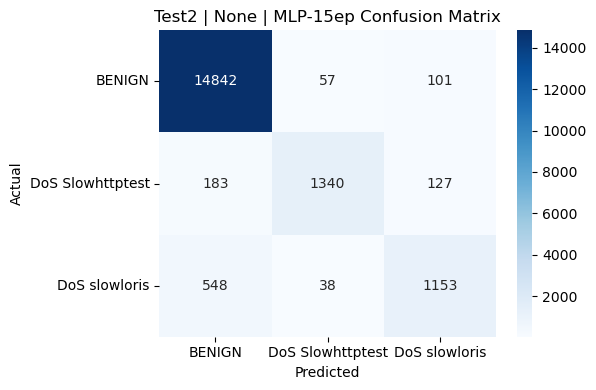

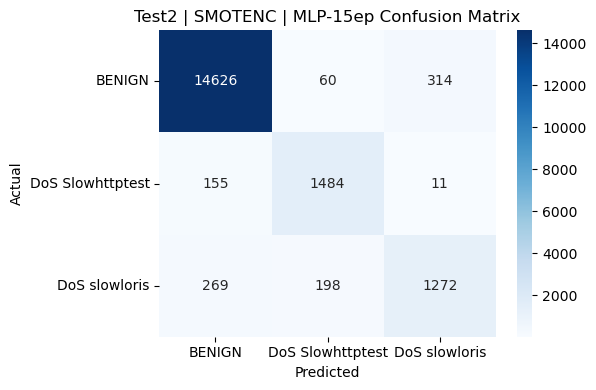

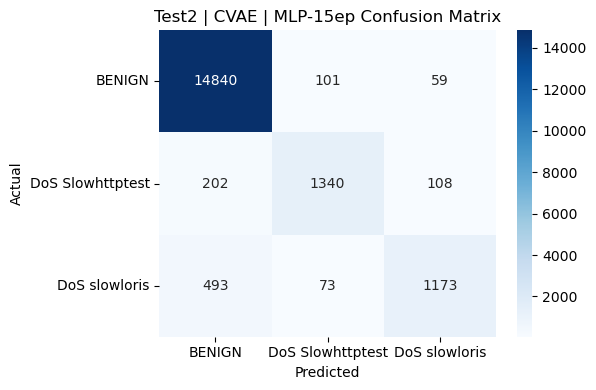

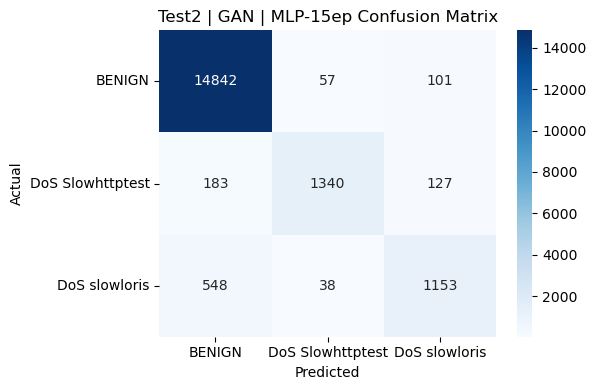

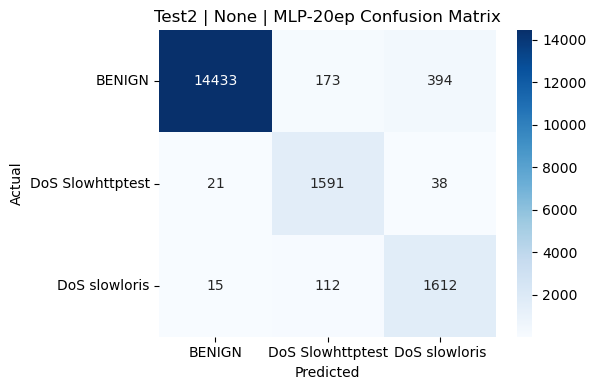

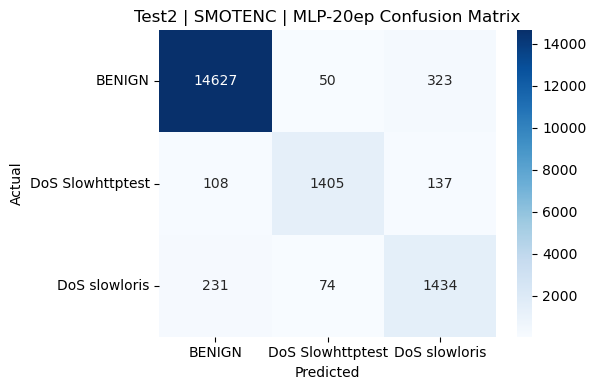

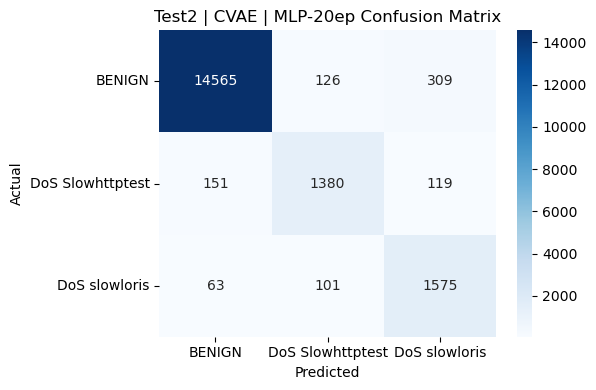

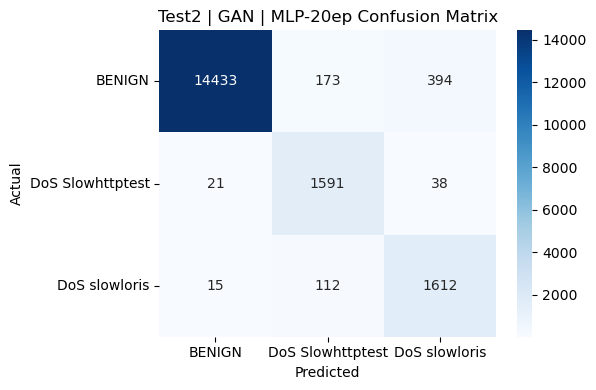

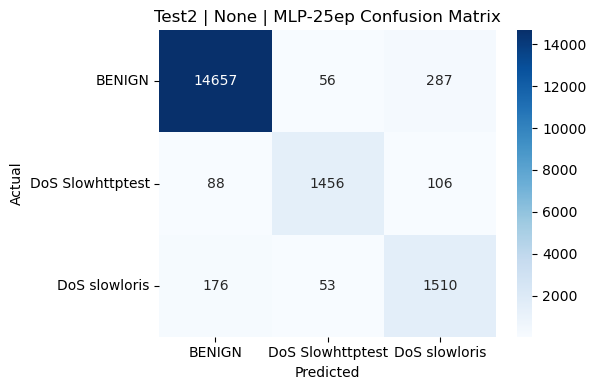

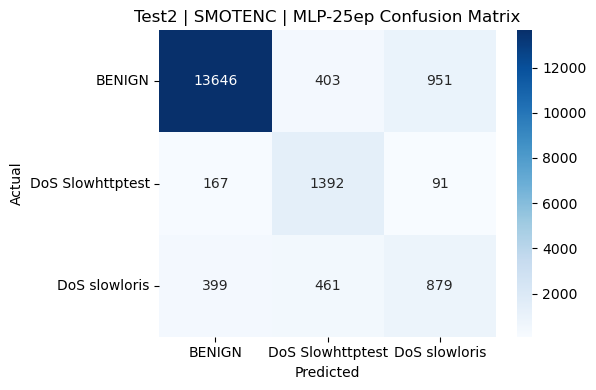

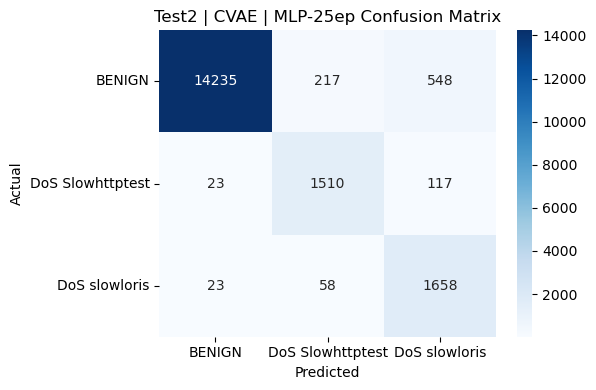

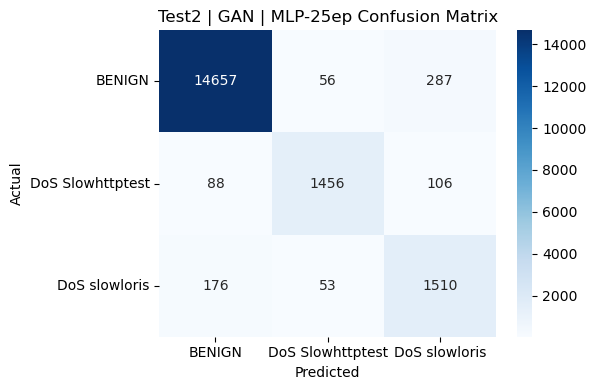

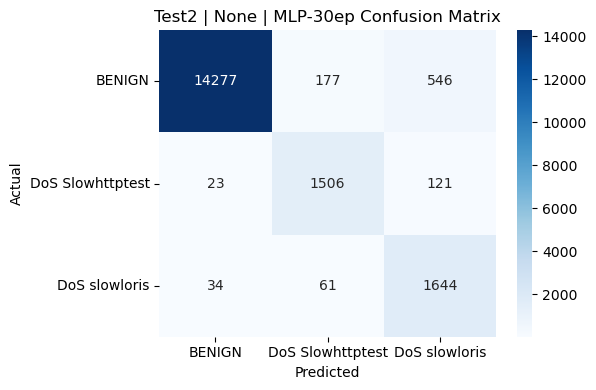

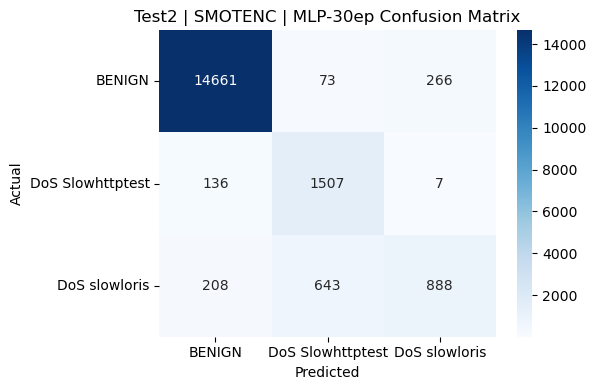

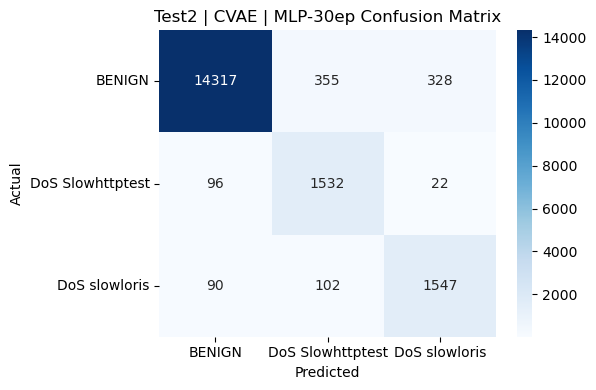

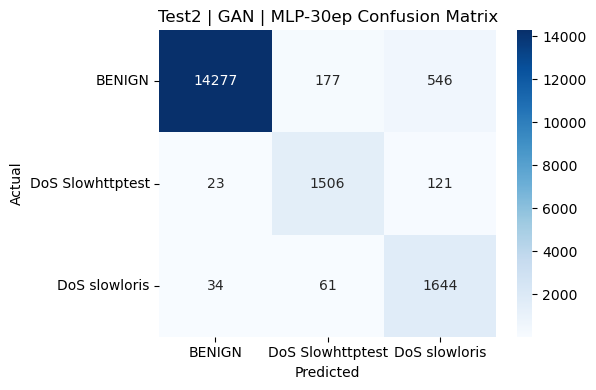

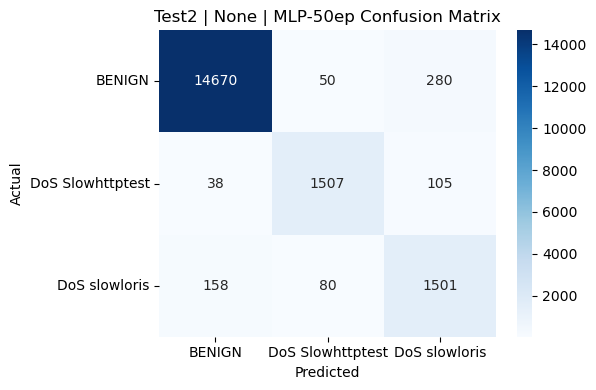

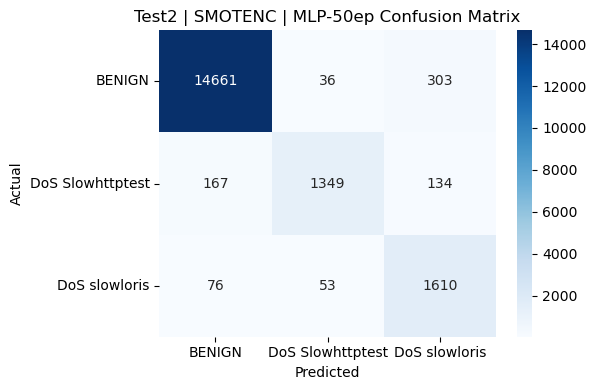

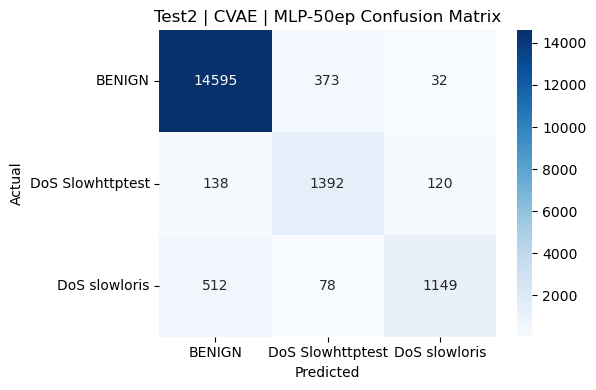

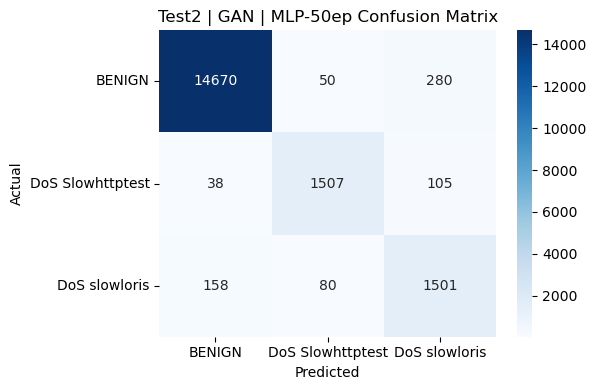

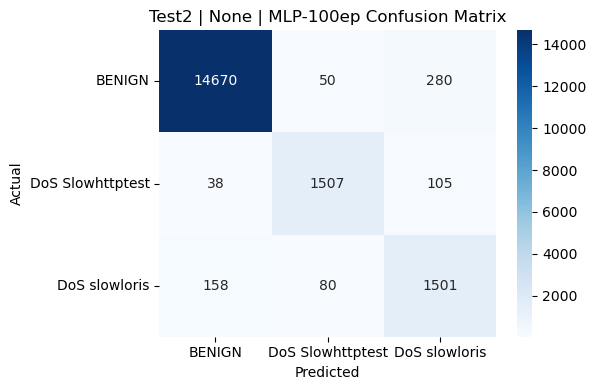

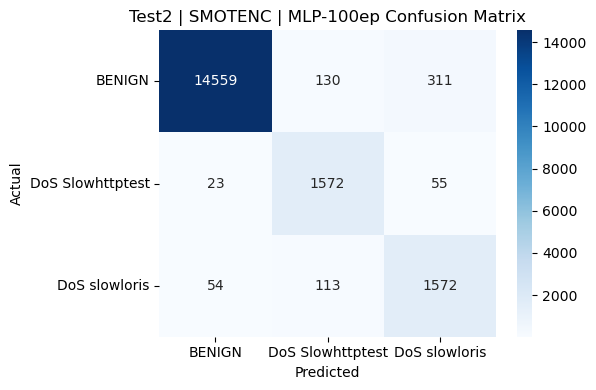

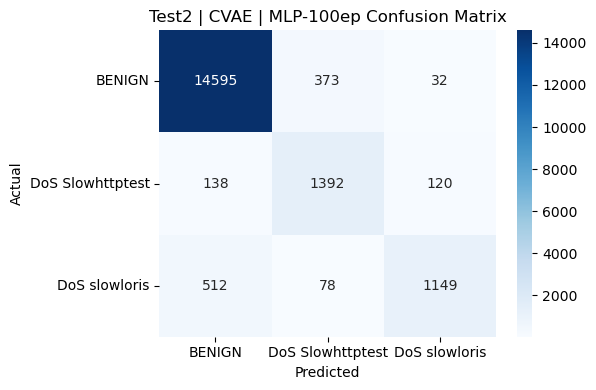

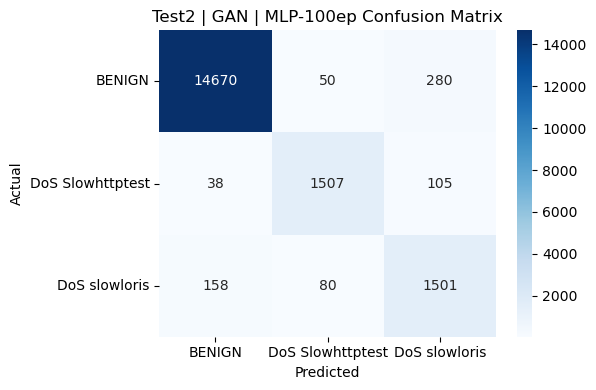

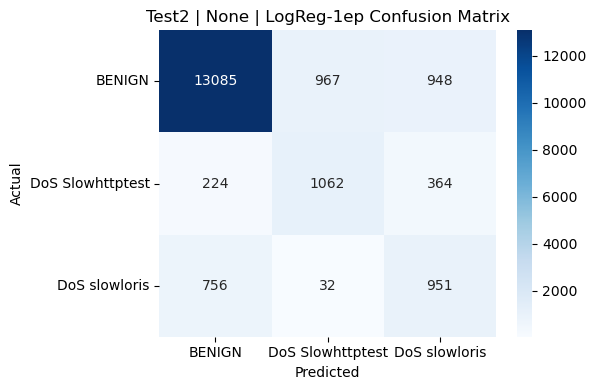

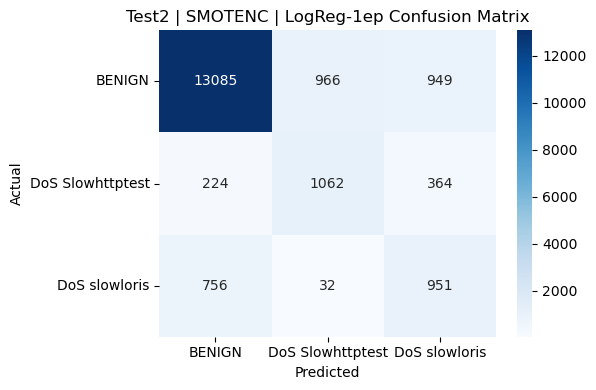

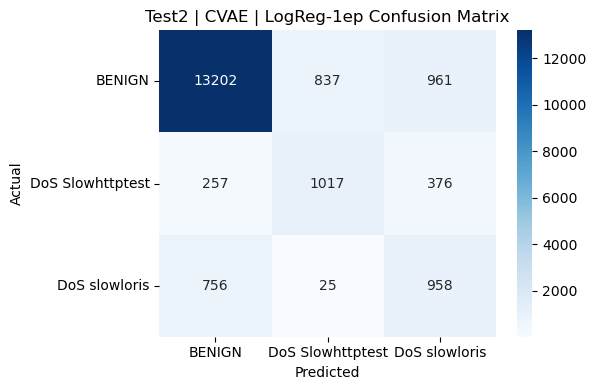

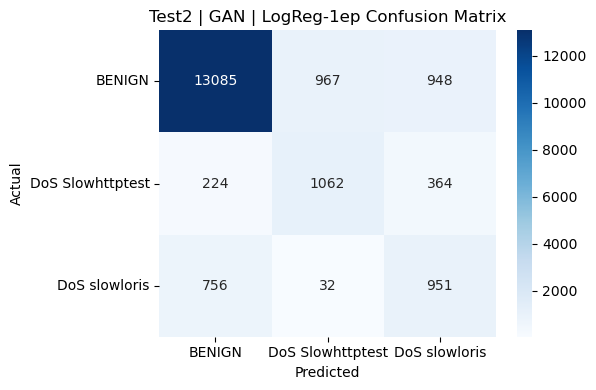

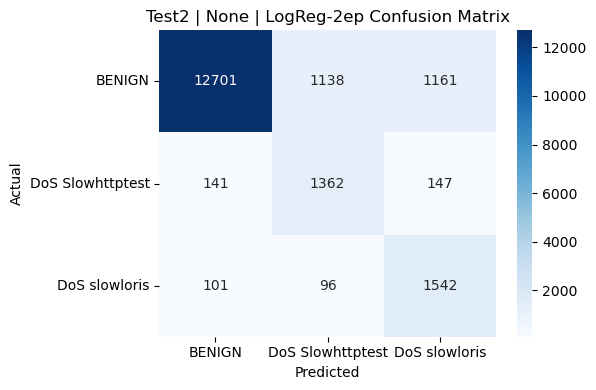

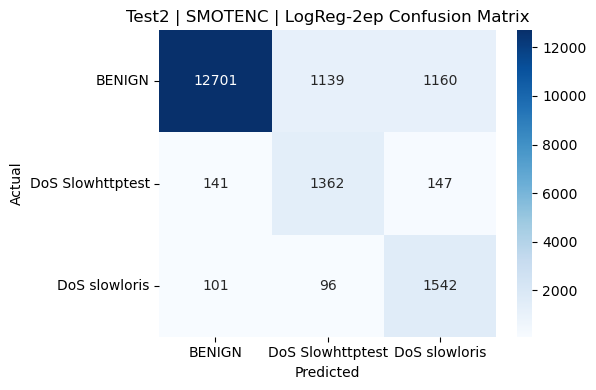

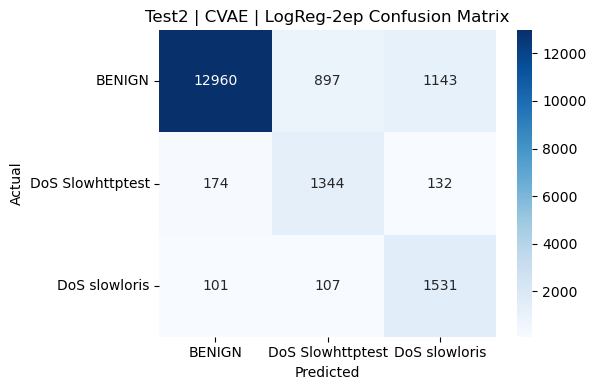

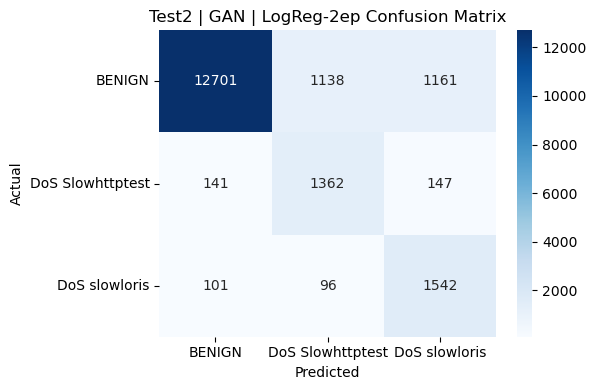

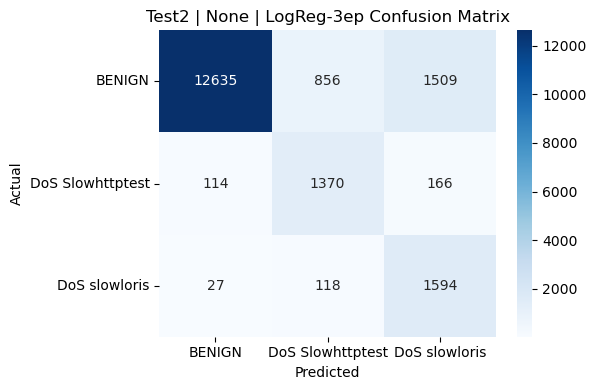

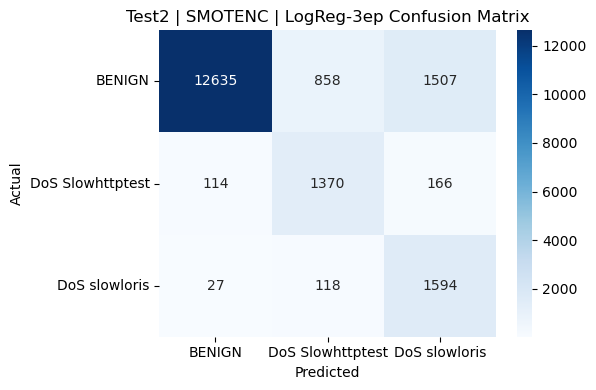

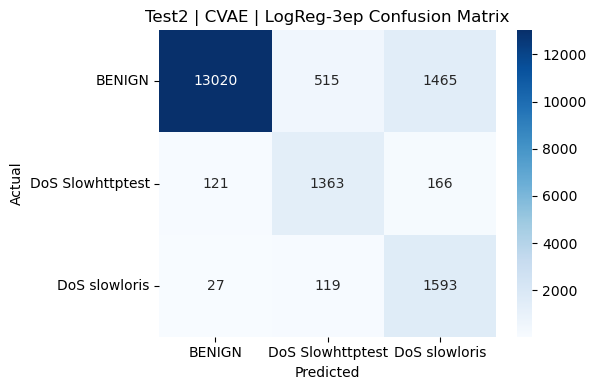

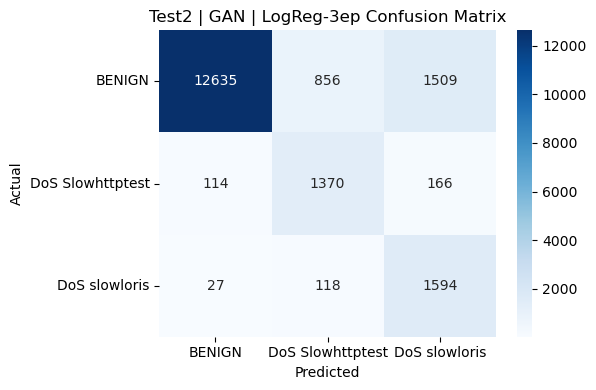

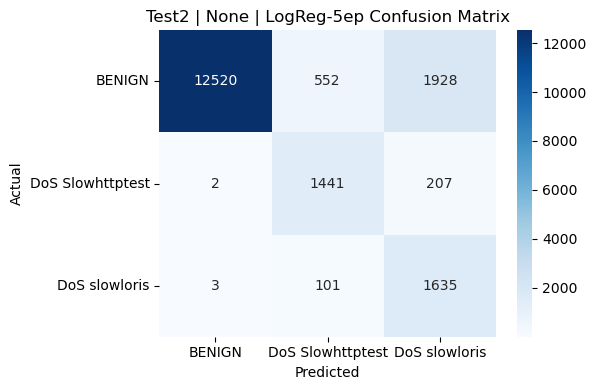

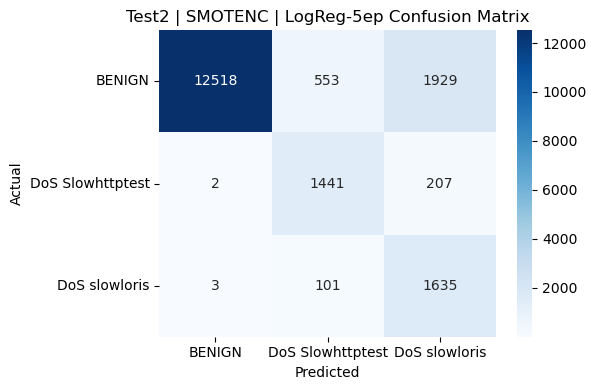

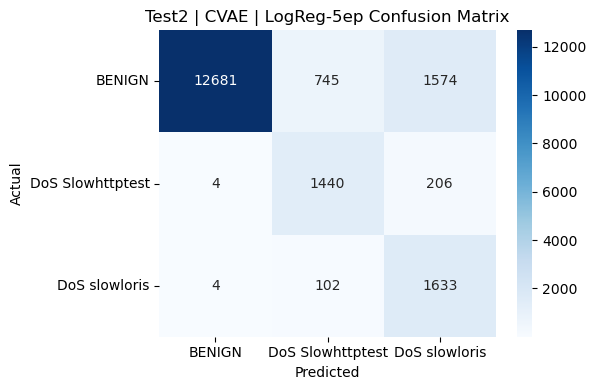

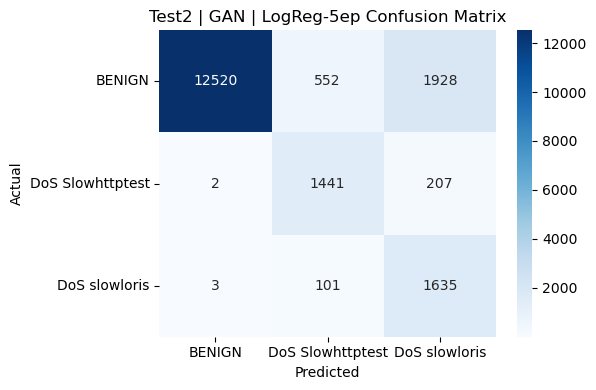

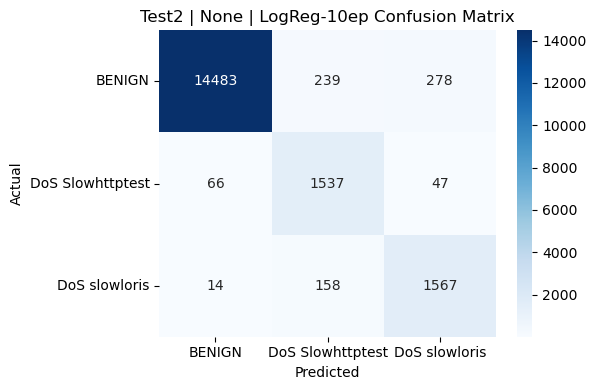

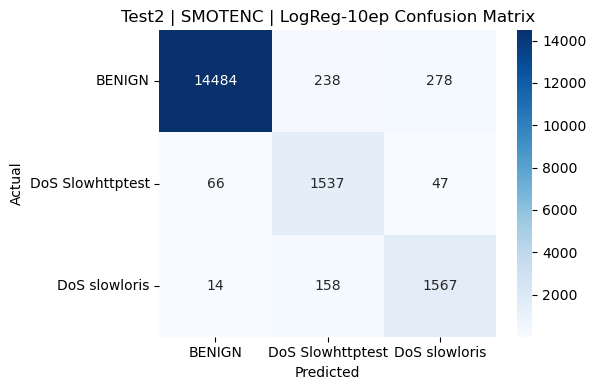

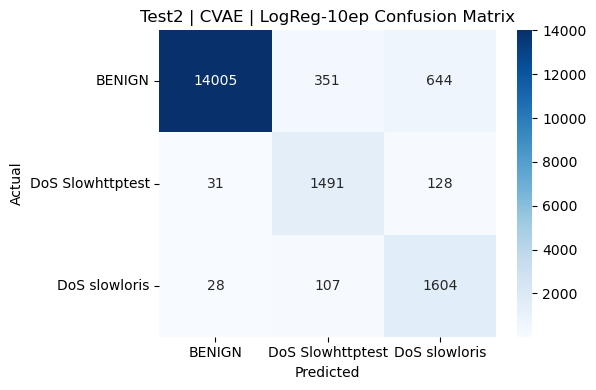

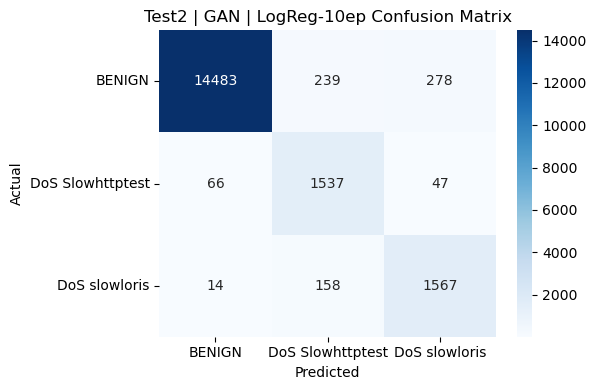

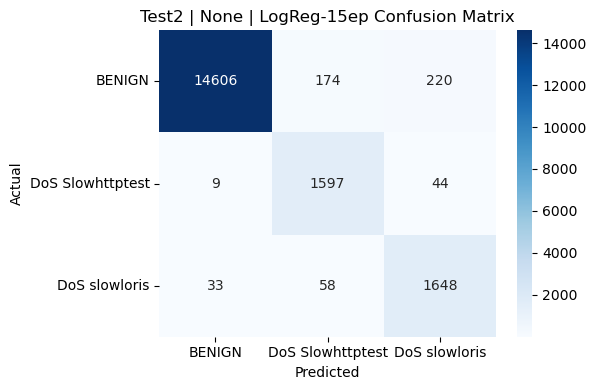

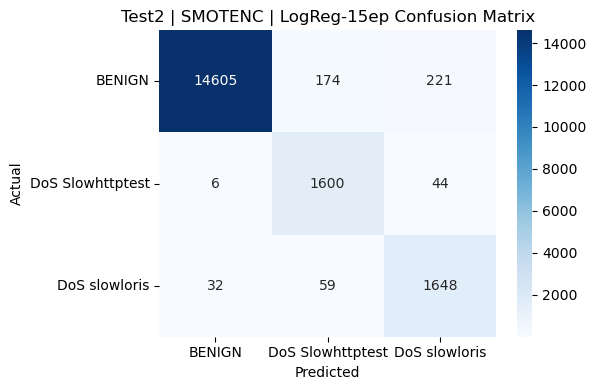

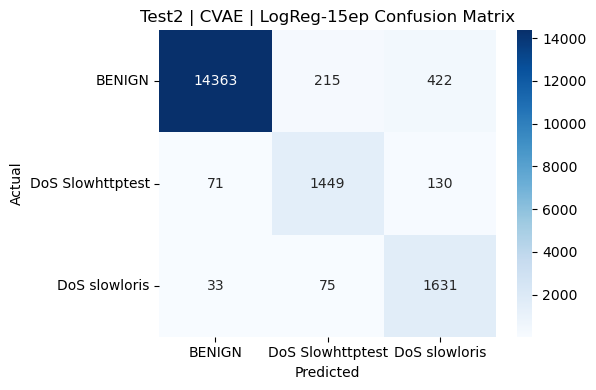

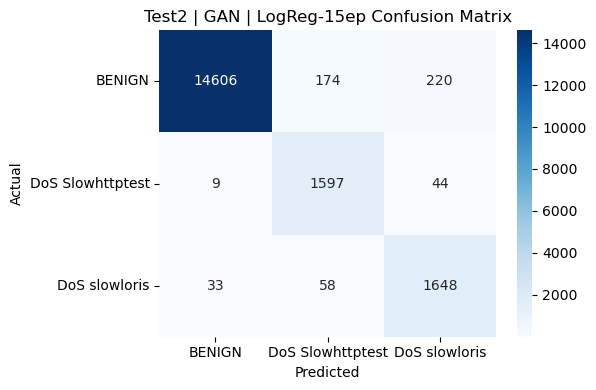

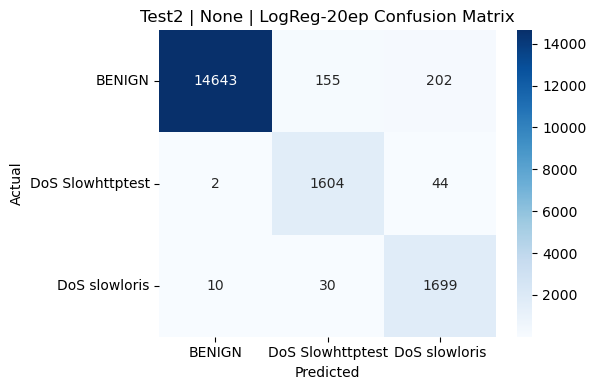

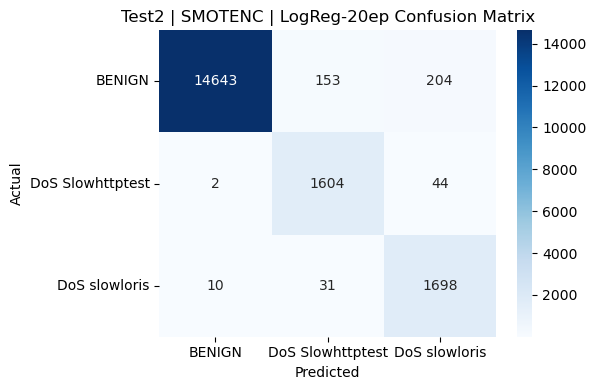

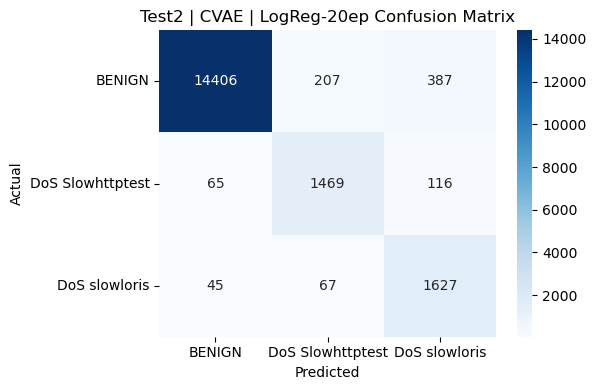

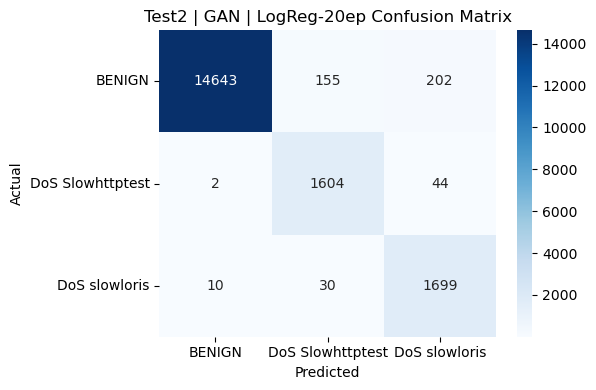

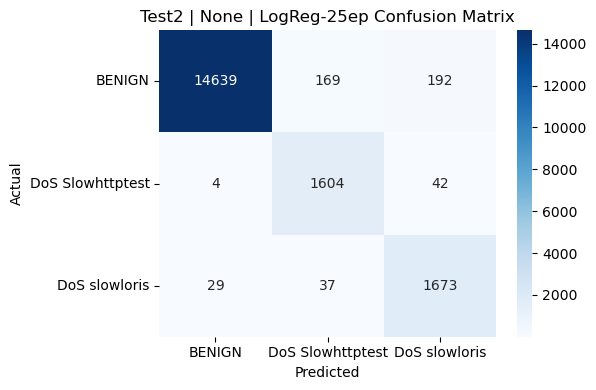

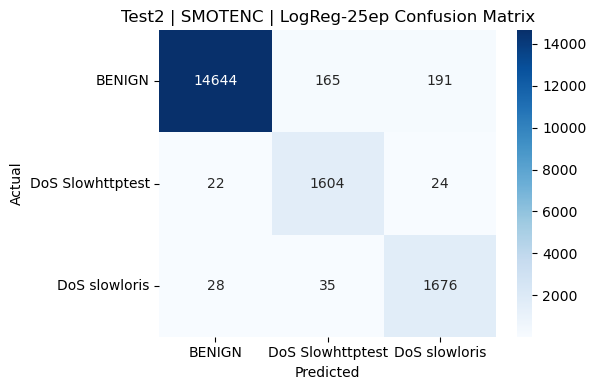

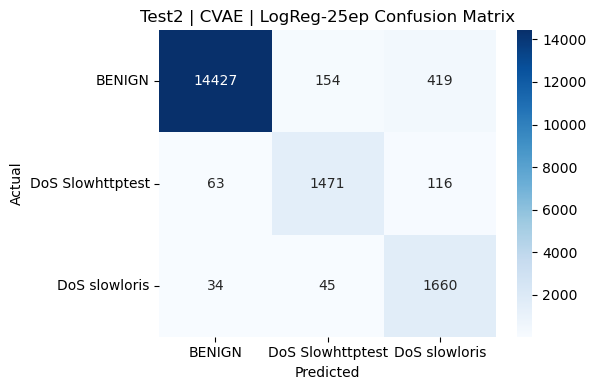

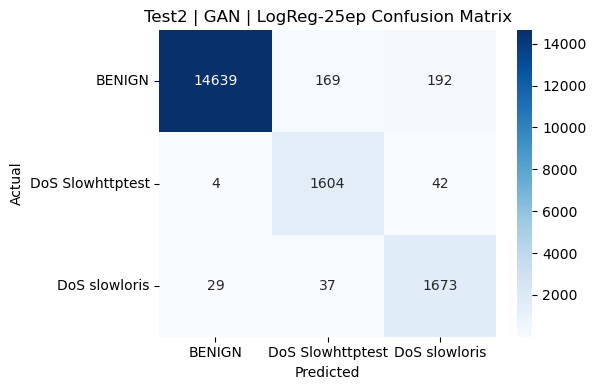

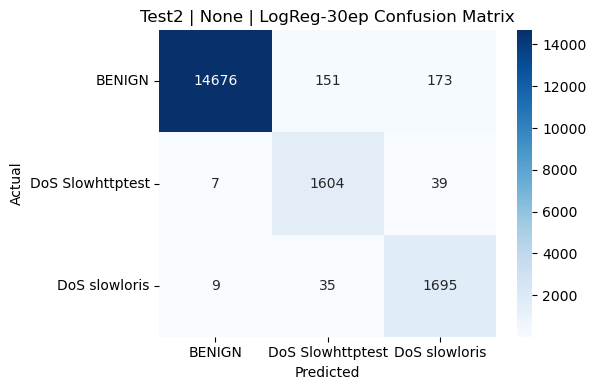

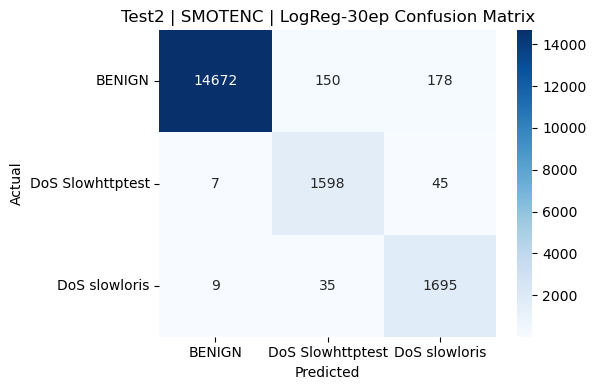

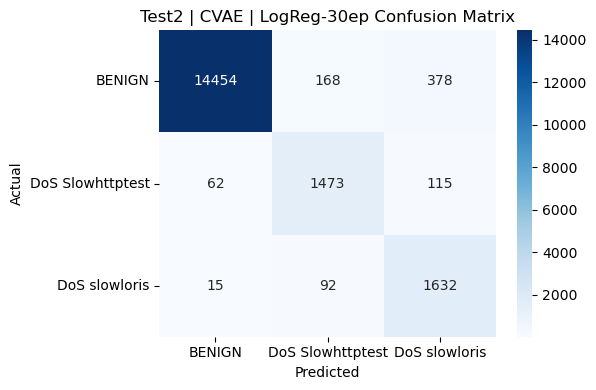

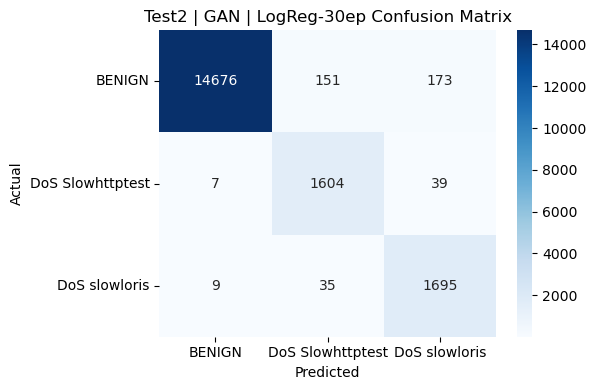

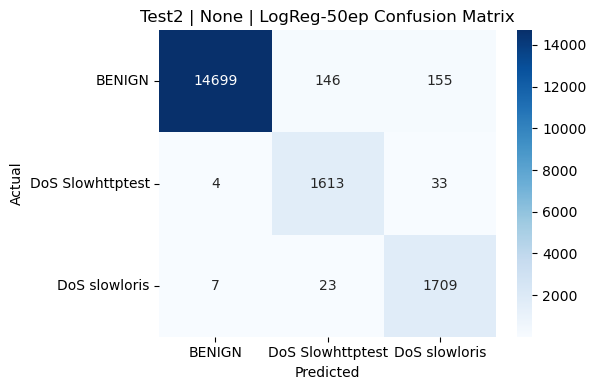

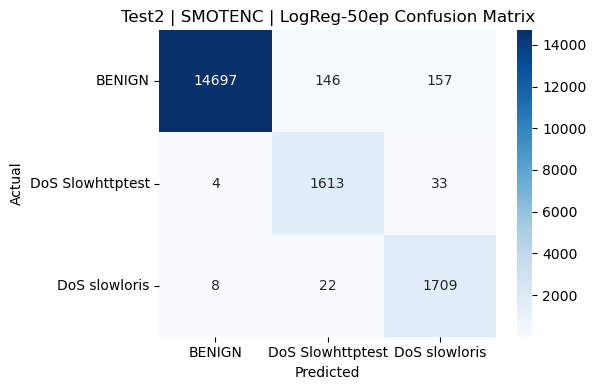

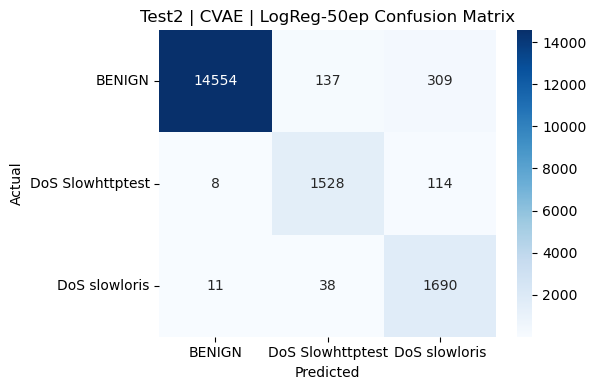

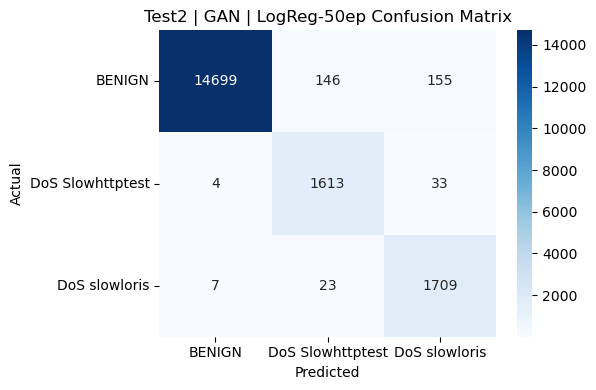

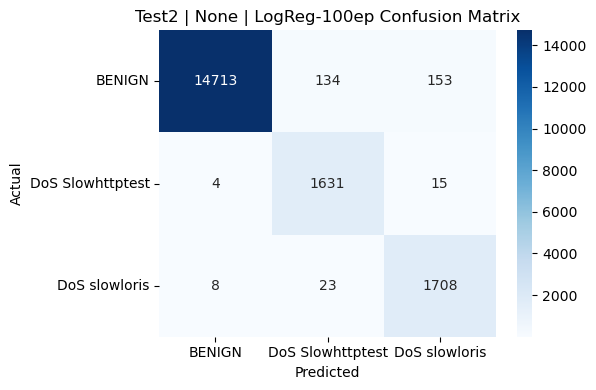

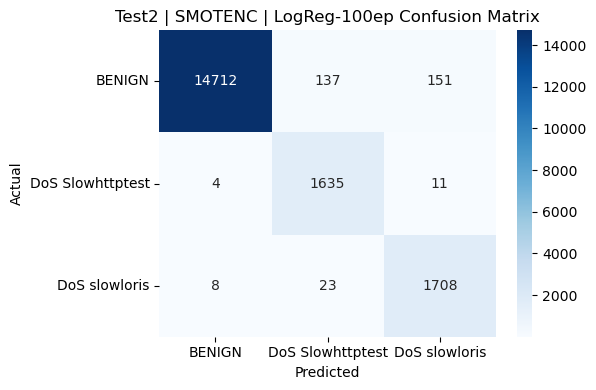

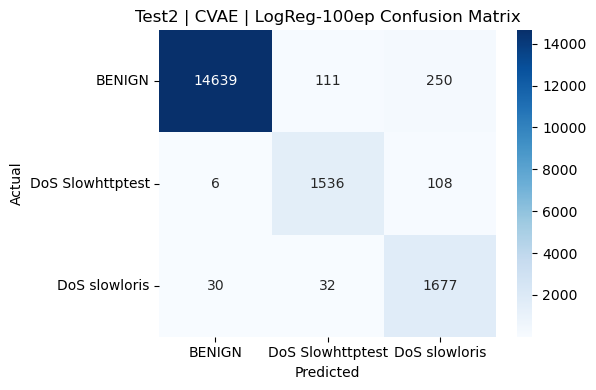

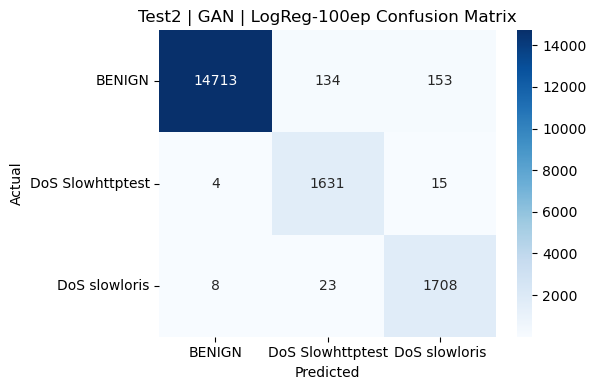

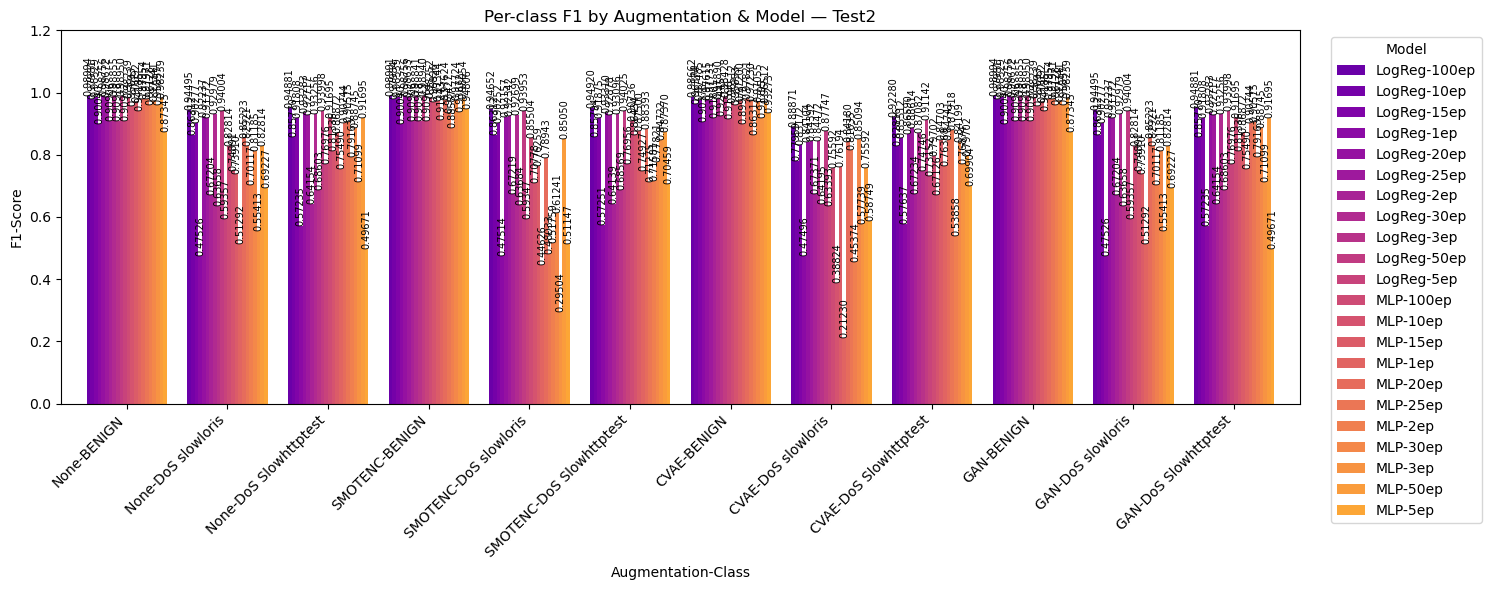

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Read the aggregated CSV files
df_cm = pd.read_csv('results/confusion_matrices_all.csv')
df_cr = pd.read_csv('results/classification_reports_all.csv')

# 2) Handle empty/null values in Augmentation column
for df in (df_cm, df_cr):
    df['Augmentation'] = df['Augmentation'].replace('', 'None').fillna('None')

# 3) Compute Macro-F1 (average per-class F1-Score by Scenario, Augmentation, Model)
df_macro = (
    df_cr
    .groupby(['Scenario','Augmentation','Model'])['F1-Score']
    .mean()
    .reset_index(name='MacroF1')
)

# Define epoch range
epoch_range = [1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 100]

# Define test order
#test_order  = ['Test1', 'Test2', 'Test3', 'Test4']
test_order  = ['Test2']
methods     = ['None', 'SMOTENC', 'CVAE', 'GAN']
classes     = ['BENIGN', 'DoS slowloris', 'DoS Slowhttptest']
# Generate model list for iteration order
models_list = [f'MLP-{ep}ep' for ep in epoch_range] + [f'LogReg-{ep}ep' for ep in epoch_range]
cmap        = plt.get_cmap('plasma')

# 4) Plot Macro-F1 by Scenario, Augmentation, Model
for test in test_order:
    for model in models_list:
        for method in methods:
            sub = df_cm[
                (df_cm['Scenario']     == test) &
                (df_cm['Model']        == model) &
                (df_cm['Augmentation'] == method)
            ]
            if sub.empty:
                continue
            # Extract prediction columns and build matrix
            preds  = [c for c in sub.columns if c.startswith('Pred_')]
            cm_mat = sub.set_index('ActualClass')[preds]
            cm_mat.columns = [c.replace('Pred_','') for c in preds]

            plt.figure(figsize=(6,4))
            ax = sns.heatmap(
                cm_mat,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=cm_mat.columns,
                yticklabels=cm_mat.index
            )
            # Horizontal display of tick labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

            plt.title(f'{test} | {method} | {model} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()

# 5) Plot per-class F1 bar chart: Augmentation-Class on x-axis
for test in test_order:
    df_t = df_cr[df_cr['Scenario'] == test]
    if df_t.empty:
        continue

    # Construct AugClass label and pivot
    df_t = df_t.copy()
    df_t['AugClass'] = df_t['Augmentation'] + '-' + df_t['Class']
    df_pivot = df_t.pivot(index='AugClass', columns='Model', values='F1-Score')

    # 5) Reorder rows by methods × classes
    order = [f"{m}-{c}" for m in methods for c in classes]
    df_pivot = df_pivot.reindex(order).fillna(0)

    # 6) Plot
    colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(models_list))]
    ax = df_pivot.plot(
        kind='bar',
        figsize=(15, 6),
        color=colors,
        width=0.8
    )
    plt.title(f'Per-class F1 by Augmentation & Model — {test}')
    plt.xlabel('Augmentation-Class')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1.2)
    ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')

    # Annotate values
    for p in ax.patches:
        h = p.get_height()
        if not np.isnan(h):
            ax.annotate(
                f'{h:.5f}',
                (p.get_x() + p.get_width() / 2, h),
                ha='center', va='bottom', rotation='vertical', fontsize=7
            )

    plt.tight_layout()
    plt.show()